# **Multiclass Image Classification - Rock Paper Scissors Dataset.**

> [**Kaggle Dataset**](https://www.kaggle.com/datasets/sanikamal/rock-paper-scissors-dataset)

In [ ]:
# Install Kaggle.
!pip install --upgrade --force-reinstall --no-deps kaggle

In [ ]:
# Files Upload.
from google.colab import files

files.upload()

In [ ]:
# Create a Kaggle Folder.
!mkdir ~/.kaggle

# Copy the kaggle.json to the folder created.
!cp kaggle.json ~/.kaggle/

# Permission for the json file to act.
!chmod 600 ~/.kaggle/kaggle.json

In [ ]:
# Dataset Download.
!kaggle datasets download -d sanikamal/rock-paper-scissors-dataset

In [ ]:
# Unzip Dataset.
!unzip rock-paper-scissors-dataset.zip

## **Multiclass Classification with Image Augmentation.**

In [ ]:
# Import Library.
import os, random
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator, load_img
import warnings

warnings.filterwarnings("ignore")

base_dir = os.path.join("/content/Rock-Paper-Scissors")
print("Base Directory --> ", os.listdir(base_dir))

Base Directory -->  ['validation', 'train', 'test']


#### **Define Dataset Path.**

In [ ]:
# Train Set.
train_dir = os.path.join("/content/Rock-Paper-Scissors/train")
print("Train --> ", os.listdir(train_dir))

# Test Set.
test_dir = os.path.join("/content/Rock-Paper-Scissors/test")
print("Test --> ", os.listdir(test_dir))

# Validation Set.
validation_dir = os.path.join("/content/Rock-Paper-Scissors/validation")
print("Validation --> ", os.listdir(validation_dir)[:5])

Train -->  ['scissors', 'paper', 'rock']
Test -->  ['scissors', 'paper', 'rock']
Validation -->  ['paper6.png', 'paper2.png', 'paper-hires2.png', 'rock4.png', 'paper5.png']


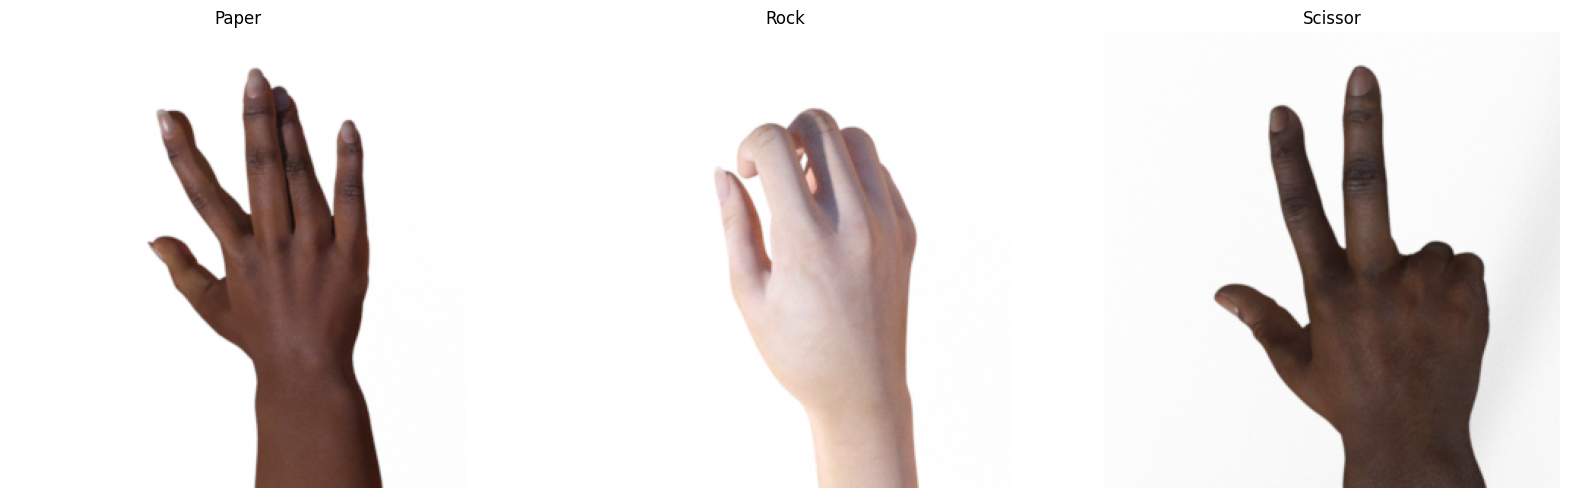

In [ ]:
# Display random images from the dataset.

fig, ax = plt.subplots(1, 3, figsize=(20, 10))

sample_paper = random.choice(os.listdir(train_dir + "/paper"))
image = load_img(train_dir + "/paper/" + sample_paper)
ax[0].imshow(image)
ax[0].set_title("Paper")
ax[0].axis("Off")

sample_rock = random.choice(os.listdir(train_dir + "/rock"))
image = load_img(train_dir + "/rock/" + sample_rock)
ax[1].imshow(image)
ax[1].set_title("Rock")
ax[1].axis("Off")

sample_scissor = random.choice(os.listdir(train_dir + "/scissors"))
image = load_img(train_dir + "/scissors/" + sample_scissor)
ax[2].imshow(image)
ax[2].set_title("Scissor")
ax[2].axis("Off")

plt.show()

#### **Define the CNN Model.**

In [ ]:
model = tf.keras.models.Sequential(
    [
        tf.keras.layers.Conv2D(
            32, (3, 3), activation="relu", input_shape=(150, 150, 3)
        ),
        tf.keras.layers.MaxPooling2D(2, 2),
        tf.keras.layers.Conv2D(64, (3, 3), activation="relu"),
        tf.keras.layers.MaxPooling2D(2, 2),
        tf.keras.layers.Conv2D(128, (3, 3), activation="relu"),
        tf.keras.layers.MaxPooling2D(2, 2),
        tf.keras.layers.Conv2D(128, (3, 3), activation="relu"),
        tf.keras.layers.MaxPooling2D(2, 2),
        tf.keras.layers.Flatten(),
        tf.keras.layers.Dense(256, activation="relu"),
        tf.keras.layers.Dense(3, activation="softmax"),
    ]
)

# Compile the Model.
model.compile(loss="categorical_crossentropy", optimizer="adam", metrics=["accuracy"])

model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 148, 148, 32)      896       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 74, 74, 32)       0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 72, 72, 64)        18496     
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 36, 36, 64)       0         
 2D)                                                             
                                                                 
 conv2d_2 (Conv2D)           (None, 34, 34, 128)       73856     
                                                                 
 max_pooling2d_2 (MaxPooling  (None, 17, 17, 128)      0

In [ ]:
class myCallback(tf.keras.callbacks.Callback):
    def on_epoch_end(self, epoch, logs={}):
        if logs.get("accuracy") > 0.95:
            print("\nReached > 95% accuracy, so canceling training!")
            self.model.stop_training = True


callbacks = myCallback()

### **Training & Validation Generator with Image Augmentation.**

**The dataset is imbalanced. Use the data augmentation technique to increase the number of training examples.**

To avoid the overfitting problem, we need to expand our dataset artificially. We can make our existing dataset even larger. The idea is to alter the training data with small transformations to reproduce the variations. Approaches that alter the training data in ways that change the array representation while keeping the label the same are known as data augmentation techniques. Popular augmentations techniques are grayscales, horizontal flips, vertical flips, random crops, color jitters, translations, rotations, etc. Applying some of these transformations to our training dataset can increase the number of training examples and helps create a robust model.

In [ ]:
train_datagen = ImageDataGenerator(
    rescale=1.0 / 255,
    rotation_range=40,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode="nearest",
)

train_generator = train_datagen.flow_from_directory(
    train_dir, target_size=(150, 150), class_mode="categorical", batch_size=20
)

Found 2520 images belonging to 3 classes.


In [ ]:
validation_datagen = ImageDataGenerator(rescale=1.0 / 255)

validation_generator = validation_datagen.flow_from_directory(
    test_dir, target_size=(150, 150), class_mode="categorical", batch_size=20
)

Found 372 images belonging to 3 classes.


#### **Fit the Model.**

In [ ]:
# Fit the Model.
history = model.fit_generator(
    train_generator,
    steps_per_epoch=np.ceil(2520 / 20),
    epochs=10,
    validation_data=validation_generator,
    validation_steps=np.ceil(372 / 20),
    callbacks=[callbacks],
    verbose=2,
)

Epoch 1/10
126/126 - 171s - loss: 0.9946 - accuracy: 0.4536 - val_loss: 0.4664 - val_accuracy: 0.7124 - 171s/epoch - 1s/step
Epoch 2/10
126/126 - 164s - loss: 0.4820 - accuracy: 0.8032 - val_loss: 0.0984 - val_accuracy: 0.9731 - 164s/epoch - 1s/step
Epoch 3/10
126/126 - 171s - loss: 0.2403 - accuracy: 0.9155 - val_loss: 0.1240 - val_accuracy: 0.9651 - 171s/epoch - 1s/step
Epoch 4/10
126/126 - 162s - loss: 0.1816 - accuracy: 0.9321 - val_loss: 0.0850 - val_accuracy: 0.9651 - 162s/epoch - 1s/step
Epoch 5/10

Reached > 95% accuracy, so canceling training!
126/126 - 164s - loss: 0.1287 - accuracy: 0.9556 - val_loss: 0.0618 - val_accuracy: 0.9785 - 164s/epoch - 1s/step


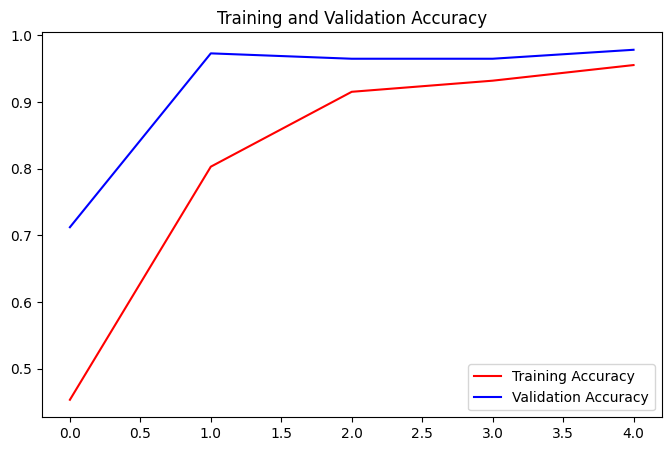

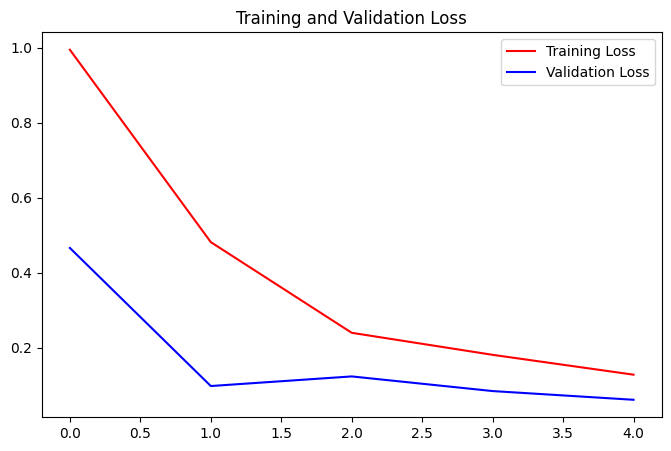

In [ ]:
# Visualize Training Performance.

acc = history.history["accuracy"]
val_acc = history.history["val_accuracy"]
loss = history.history["loss"]
val_loss = history.history["val_loss"]

epochs = range(len(acc))

plt.figure(figsize=(8, 5))

plt.plot(epochs, acc, "r", label="Training Accuracy")
plt.plot(epochs, val_acc, "b", label="Validation Accuracy")
plt.title("Training and Validation Accuracy")
plt.legend()

plt.figure(figsize=(8, 5))

plt.plot(epochs, loss, "r", label="Training Loss")
plt.plot(epochs, val_loss, "b", label="Validation Loss")
plt.title("Training and Validation Loss")
plt.legend()

plt.show()

#### **Prepare the Test Data.**

In [ ]:
test_img = os.listdir(os.path.join(validation_dir))

test_df = pd.DataFrame({"Image": test_img})
test_df.head()

,Image
0,paper6.png
1,paper2.png
2,paper-hires2.png
3,rock4.png
4,paper5.png


#### **Test Generator.**

In [ ]:
test_gen = ImageDataGenerator(rescale=1.0 / 255)

test_generator = test_gen.flow_from_dataframe(
    test_df,
    validation_dir,
    x_col="Image",
    y_col=None,
    class_mode=None,
    target_size=(150, 150),
    batch_size=20,
    shuffle=False,
)

Found 33 validated image filenames.


In [ ]:
# Model Predictions.
predict = model.predict_generator(test_generator, steps=int(np.ceil(33 / 20)))

In [ ]:
# Identify the Class.
label_map = dict((v, k) for k, v in train_generator.class_indices.items())
label_map

{0: 'paper', 1: 'rock', 2: 'scissors'}

In [ ]:
test_df["Label"] = np.argmax(predict, axis=-1)

test_df["Label"] = test_df["Label"].replace(label_map)

test_df.head()

,Image,Label
0,paper6.png,paper
1,paper2.png,paper
2,paper-hires2.png,paper
3,rock4.png,rock
4,paper5.png,paper


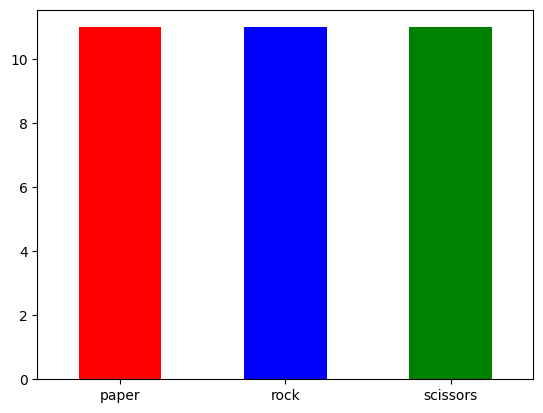

In [ ]:
test_df.Label.value_counts().plot.bar(color=["red", "blue", "green"])
plt.xticks(rotation=0)
plt.show()

#### **Model Performance Result with Unseen Images.**

In [ ]:
v = random.randint(0, 25)
sample_test = test_df.iloc[v : (v + 18)].reset_index(drop=True)
sample_test.head()

plt.figure(figsize=(12, 24))
for index, row in sample_test.iterrows():
    filename = row["Image"]
    category = row["Label"]
    img = load_img(validation_dir + "/" + filename, target_size=(150, 150))
    plt.subplot(6, 3, index + 1)
    plt.imshow(img)
    plt.xlabel(filename + " [Prediction = " + "{}".format(category) + " ]")
plt.tight_layout()
plt.show()

In [ ]:
# Model Accuracy.
lis = []
for ind in test_df.index:
    if test_df["Label"][ind] in test_df["Image"][ind]:
        lis.append(1)
    else:
        lis.append(0)

print(
    "Accuracy of the Model on Test Data is {:.2f}".format((sum(lis) / len(lis)) * 100)
)

Accuracy of the Model on Test Data is 100.00
